<a href="https://colab.research.google.com/github/leogalbu/Colab_Notebook/blob/Image_Classification/Transfer_Learning_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transfer Learning  - Feature Extraction

In [14]:
import zipfile
import os
import pathlib
import datetime

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard
import tensorflow_hub as hub
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Downloading the data

In [3]:
# Use 10% of the data of the previous notebook
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2022-09-02 13:47:33--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 142.250.141.128, 2607:f8b0:4023:c0d::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   195MB/s    in 0.8s    

2022-09-02 13:47:34 (195 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
# Walk the directories
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f"there are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

there are 2 directories and 0 images in '10_food_classes_10_percent'
there are 10 directories and 0 images in '10_food_classes_10_percent/train'
there are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'
there are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'
there are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'
there are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'
there are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'
there are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'
there are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'
there are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'
there are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'
there are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburge

## Prepare data using ImageDataGenerator

In [4]:
# Setup data input
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32
EPOCHS = 5

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(train_dir, target_size=IMAGE_SHAPE, batch_size=BATCH_SIZE, class_mode='categorical')
test_data = test_datagen.flow_from_directory(test_dir, target_size=IMAGE_SHAPE, batch_size=BATCH_SIZE, class_mode='categorical')

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Callbacks (Tensorflow/Keras)

* Tracking expriments withn Tensorboard callback
* ModelChekcpoint
* Stopping model from training with EarlyStopping

In [34]:
# Buuild a function for TensorBoard Callback
def create_tensorboard_callback(dir_name, experiment_name):
  # Create a directory
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = TensorBoard(log_dir=log_dir)
  print(f"Saving tensorboard log file to: {log_dir}")
  return tensorboard_callback

## Create Models using Tensorflow HUB

In [13]:
# Compare two models 
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [22]:
# Create a model function
def create_model(model_url, num_classes=10):
  # Download the pretrained Keras Layers
  feature_extractor_layer = hub.KerasLayer(model_url, 
                                           trainable=False, # Freeze the already learned patterns/weights
                                           name="feature_extractio_layer", 
                                           input_shape=IMAGE_SHAPE+(3,)) 
  # Create the model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])

  return model


## Create ResNet Model


In [23]:
resnet_model = create_model(resnet_url, num_classes=10)

In [24]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractio_layer (Ke  (None, 2048)             23564800  
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [30]:
# Compile resnet
resnet_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam())

In [36]:
# Fit the model
resnet_history = resnet_model.fit(train_data, epochs=EPOCHS, steps_per_epoch=len(train_data), validation_data=test_data, validation_steps=len(test_data), callbacks=[create_tensorboard_callback(dir_name='tensorboard_hub', experiment_name='resnet50V2')])

Saving tensorboard log file to: tensorboard_hub/resnet50V2/20220902-131115
Epoch 1/5
24/24 [==============================] - 32s 741ms/step - loss: 1.9395 - accuracy: 0.3440 - val_loss: 1.2223 - val_accuracy: 0.6168
Epoch 2/5
24/24 [==============================] - 16s 672ms/step - loss: 0.9356 - accuracy: 0.7160 - val_loss: 0.8865 - val_accuracy: 0.7132
Epoch 3/5
24/24 [==============================] - 15s 661ms/step - loss: 0.6355 - accuracy: 0.8187 - val_loss: 0.7549 - val_accuracy: 0.7604
Epoch 4/5
24/24 [==============================] - 15s 664ms/step - loss: 0.4906 - accuracy: 0.8693 - val_loss: 0.7048 - val_accuracy: 0.7720
Epoch 5/5
24/24 [==============================] - 16s 670ms/step - loss: 0.3892 - accuracy: 0.9013 - val_loss: 0.6734 - val_accuracy: 0.7828


In [39]:
def plot_loss_curves (history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['accuracy']))

  plt.plot(epochs, loss, label='Training loss')
  plt.plot(epochs, val_loss, label='Val Loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()
  plt.figure()
  plt.plot(epochs, accuracy, label='Training Accuracy')
  plt.plot(epochs, val_accuracy, label='Val Accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')

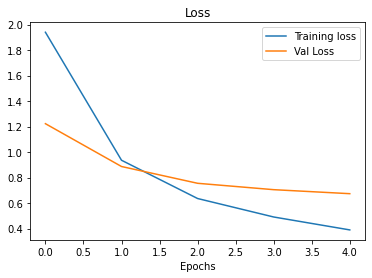

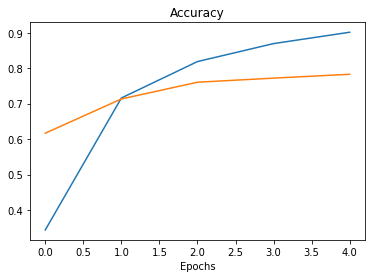

In [40]:
plot_loss_curves(resnet_history)


## EfficientNet Model

In [41]:
efficientnet_model = create_model(efficientnet_url, num_classes=10)

In [43]:
efficientnet_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam())

In [45]:
efficientnet_history = efficientnet_model.fit(train_data, epochs=EPOCHS, steps_per_epoch=len(train_data), validation_data=(test_data), validation_steps=len(test_data), callbacks=[create_tensorboard_callback(dir_name='tensorboard_hub', experiment_name='EfficientNet')])

Saving tensorboard log file to: tensorboard_hub/EfficientNet/20220902-132157
Epoch 1/5
24/24 [==============================] - 27s 742ms/step - loss: 1.8961 - accuracy: 0.4080 - val_loss: 1.3290 - val_accuracy: 0.7260
Epoch 2/5
24/24 [==============================] - 15s 648ms/step - loss: 1.0860 - accuracy: 0.7613 - val_loss: 0.8813 - val_accuracy: 0.8076
Epoch 3/5
24/24 [==============================] - 16s 696ms/step - loss: 0.7700 - accuracy: 0.8360 - val_loss: 0.7021 - val_accuracy: 0.8368
Epoch 4/5
24/24 [==============================] - 15s 660ms/step - loss: 0.6140 - accuracy: 0.8613 - val_loss: 0.6130 - val_accuracy: 0.8504
Epoch 5/5
24/24 [==============================] - 15s 639ms/step - loss: 0.5195 - accuracy: 0.8800 - val_loss: 0.5564 - val_accuracy: 0.8612


In [1]:
plot_loss_curves(efficientnet_history)


NameError: ignored

In [31]:
#plots images with labels within jupyter notebook
def plots(ims, figsize = (22,22), rows=4, interp=False, titles=None, maxNum = 9):
    if type(ims[0] is np.ndarray):
        ims = np.array(ims)
        if(ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
           
    f = plt.figure(figsize=figsize)
    #cols = len(ims) //rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    cols = maxNum // rows if maxNum % 2 == 0 else maxNum//rows + 1
    #for i in range(len(ims)):
    for i in range(maxNum):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=20)
        plt.imshow(ims[i], interpolation = None if interp else 'none')   

In [25]:
imgs, labels = train_data.next()

#print(labels)

labelNames=[]
labelIndices=[np.where(r==1)[0][0] for r in labels]
#print(labelIndices)

for ind in labelIndices:
    for labelName,labelIndex in train_data.class_indices.items():
        if labelIndex == ind:
            #print (labelName)
            labelNames.append(labelName)

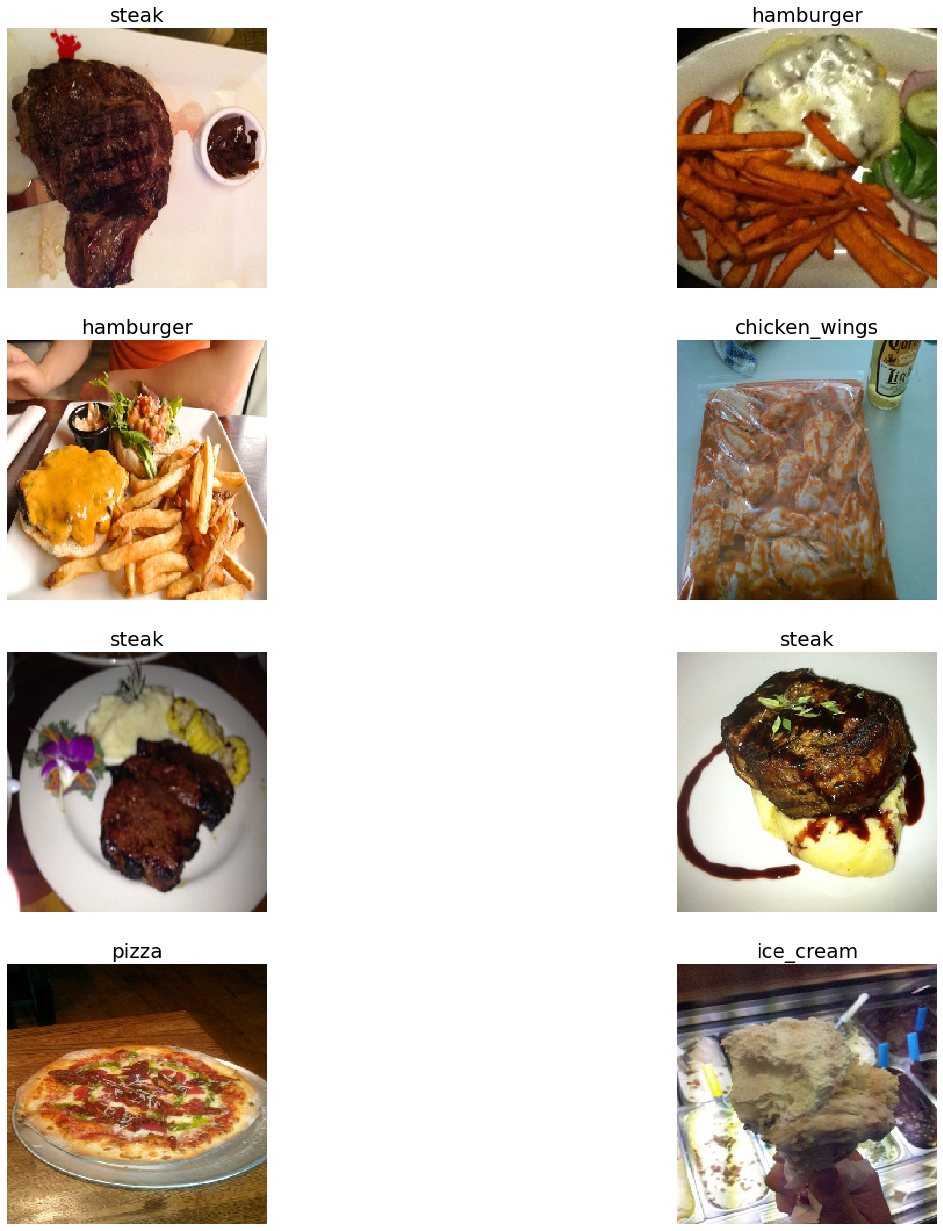

In [32]:
plots(imgs, rows=4, titles = labelNames, maxNum=8)